In [ ]:
!pip install kagglehub[pandas-datasets] pandas matplotlib

#  Kaggle API token
from google.colab import files
files.upload()  # select your kaggle.json here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kagglehub import load_dataset, KaggleDatasetAdapter

DATASET = "hugomathien/soccer"
DB_PATH = "database.sqlite"

SQL = """
SELECT
  pa.player_api_id,
  p.player_name,
  p.birthday,
  pa.date               AS snapshot_date,
  pa.overall_rating     AS current_rating,
  pa.potential
FROM Player_Attributes pa
JOIN Player p
  ON pa.player_api_id = p.player_api_id
"""

df = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    DATASET,
    DB_PATH,
    sql_query=SQL
)

df["snapshot_date"] = pd.to_datetime(df["snapshot_date"])
df["birthday"]      = pd.to_datetime(df["birthday"])
df_latest = (
    df
    .sort_values(["player_api_id","snapshot_date"])
    .groupby("player_api_id", as_index=False)
    .last()
)
df_latest["age"] = (df_latest["snapshot_date"] - df_latest["birthday"]).dt.days / 365.25


<ipython-input-4-713641b22d65>:26: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = load_dataset(


In [5]:
np.random.seed(1)
df_latest["g_a_per_90"] = np.random.uniform(0.3, 0.55, len(df_latest))


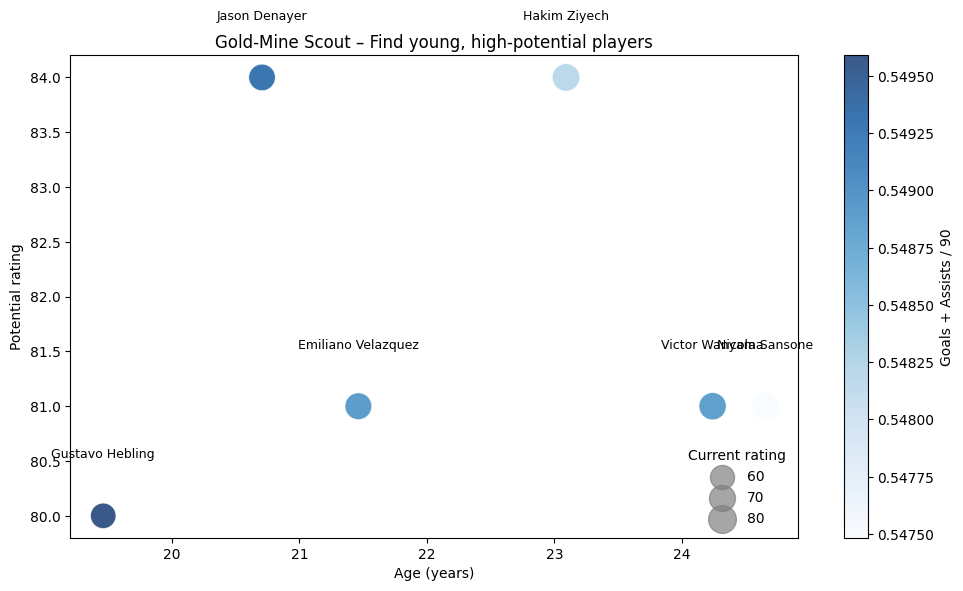

In [ ]:
plot_df = (
    df_latest
    .query("age <= 25 and potential >= 80")
    .nlargest(6, "g_a_per_90")
)

# Bubble‐chart
plt.figure(figsize=(10,6))
sc = plt.scatter(
    plot_df["age"],
    plot_df["potential"],
    s=plot_df["current_rating"] * 5,
    c=plot_df["g_a_per_90"],
    cmap="Blues",
    alpha=0.8,
    edgecolor="white",
    linewidth=0.5
)
cbar = plt.colorbar(sc)
cbar.set_label("Goals + Assists / 90")

# Legend 
for cr in [60,70,80]:
    plt.scatter([], [], s=cr*5, c="gray", alpha=0.7, label=str(cr))
plt.legend(scatterpoints=1, frameon=False, title="Current rating", loc="lower right")

plt.title("Gold-Mine Scout – Find young, high-potential players")
plt.xlabel("Age (years)")
plt.ylabel("Potential rating")

for _, r in plot_df.iterrows():
    plt.text(r["age"], r["potential"]+0.5, r["player_name"],
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
